In [6]:
# Переходим от целочисленного деления по умолчанию в стиле 2.xx
# К рациональному делению в стиле 3.хх
from __future__ import division

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline


class SpellChecker(object):
    def __init__(self):
        # Множество правельных слов.
        self.dict_0 = set()
        
        # Множество слов без одной буквы:
        # Фрагмент без одной буквы -> позиция удаленной буквы в исходном слове -> список исходных слов.
        self.dict_m = {}
        
    def check(self, word):
        return word in self.dict_0
    
    def variants(self, word):
        retval = set()
        # Варианты с добавлением одной буквы.
        for lst in self.dict_m.get(word, {}).itervalues():
            retval.update(lst)
        
        for i in xrange(len(word)):
            # Слово без i-й буквы.
            w = word[:i] + word[i+1:]
            # Вариант с удалением одной буквы.
            if w in self.dict_0:
                retval.add(w)
            # Варианты с заменой одной буквы.
            try:
                retval.update(self.dict_m[w][i])
            except KeyError:
                pass
        return list(retval)

    def index(self, word):
        if word not in self.dict_0:
            self.dict_0.add(word)
            for i in xrange(len(word)):
                # Слово без i-й буквы.
                w = word[:i] + word[i+1:]
                self.dict_m.setdefault(w, {}).setdefault(i, []).append(word)
                


In [7]:
    sc = SpellChecker()
    sc.index("sdf")
    sc.index("dfg")
    sc.variants("sd"), sc.variants("sdff"), sc.variants("sdd")

(['sdf'], ['sdf'], ['sdf'])

In [8]:
# Итератор проходящий по всем словам сохраненных новостей.
import sqlite3
import re

def words_iter():
    conn = sqlite3.connect("db.sqlite")
    curr = conn.execute("SELECT title, body FROM news_tbl")
    while True:
        rows = curr.fetchmany()
        if not rows:
            break
        words = u" ".join(sum(rows, ())).lower().encode("cp866", "replace").decode("cp866")
        for w in re.split(u"[^а-яa-z]+", words):
            if w: yield w


In [9]:
import random

# Функция искажающая слово.
def misspel(word):
    mode = random.choice(["add", "remove", "replace"])
    i = random.randint(0, len(word)-1)
    if mode == "add":
        return word[:i] + "g" + word[i:]
    if mode == "remove":
        return word[:i] + word[i+1:]
    if mode == "replace":
        return word[:i] + word[0] + word[i+1:]

# Заносим в чекер 1000 уникальных слов.
sc = SpellChecker()
for word in words_iter():
    sc.index(word)
    if len(sc.dict_0) > 1000:
        break
        
# Проверяем, что можем их восстановить.
for word in sc.dict_0:
    assert word in sc.variants(misspel(word))
    

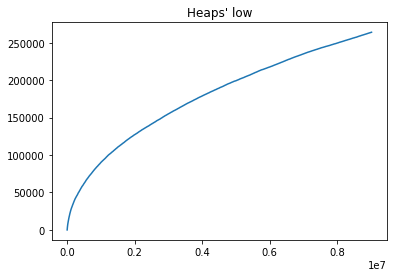

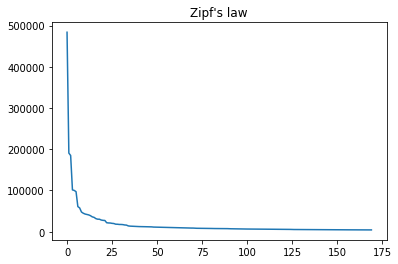

In [10]:
# Статистики Ципфа и Хипса.
import collections

N = 100000  # Максимальное число слов в выборке.
counters = collections.defaultdict(int)
n_uniques = []
n_all = []

for i, word in enumerate(words_iter()):
    if i and i % (N // 100):
        n_uniques.append(len(counters))
        n_all.append(i+1)
    counters[word] += 1
    
plt.plot(n_all, n_uniques);
plt.title("Heaps' low");

plt.figure()
plt.plot(sorted(counters.values())[::-1][:170])
plt.title("Zipf's law");